# Chapter 2: A Little More on PyMC

In [1]:
%matplotlib inline
%load_ext version_information

# Standard Library

# Third Party Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import theano.compile as tc
import theano.tensor as tt
from tqdm import tqdm_notebook as tqdm

# Local Libraries

# Local Definitions
plt.rcParams["font.size"] = 18

%version_information matplotlib,numpy,pymc3,scipy,theano

Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 16.6.0 x86_64 i386 64bit
matplotlib 2.0.2
numpy 1.12.1
pymc3 3.0
scipy 0.19.0
theano 0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291
Thu Jun 08 11:29:01 2017 MDT

## Deterministic Variables

The online documentation for working with deterministic variables in pymc3 is confusing at best. Theano is used as the back-end for pymc3 variables, but it's not always clear how to use it. For simple functions of variables, you can use a notation similar to what was used in pymc2, but without the need for a decorator. (Some documentation claims you have to use the ```@theano.compile.ops.as_op``` decorator, but if that was at any point true, it no longer is. It's unclear whether that notation is useful in more complicated setups or not, but I should keep it in mind.)

In any case, simple deterministic variables can be declared in this way:

In [31]:
def f(x, y):
    return 3*x**2 - 2*y

with pm.Model() as model1:
    x = pm.Normal("x", 5, 2)
    y = pm.Normal("y", 8, 3)

    z = pm.Deterministic("z", f(x,y))
    
    # pymc3 variables don't have a .value attribute like they do in pymc2,
    # but we can get a single random draw by tracing 1 step. No need to do
    # a tune or init, so just drop n_init to 0. That requires the Metropolis()
    # stepper; NUTS will have a fit without at least n_init = 10.
    # New alternative: no init at all.
    trace = pm.sample(1, init=None, step=pm.Metropolis())
    
print(model1.basic_RVs, model1.deterministics)
print(trace['x'][0], trace['y'][0], trace['z'][0])
print(f(trace['x'][0], trace['y'][0]))

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

[x, y] [z]
5.78692995688 7.04326620292 86.3791425718
86.3791425718


Supposedly, if that doesn't work, we should try using the ```theano.compile.ops.as_op``` decorator, like this:

In [3]:
@tc.ops.as_op(itypes=[tt.dscalar, tt.dscalar], otypes = [tt.dscalar])
def g(x, y):
    return 3*x**2-2*np.sqrt(y)

with pm.Model() as model2:
    x = pm.Normal("x", 5, 2)
    y = pm.Normal("y", 8, 3)
    
    z = pm.Deterministic("z", g(x, y))

    trace = pm.sample(1, init=None, step=pm.Metropolis())
    
print(model2.basic_RVs, model2.deterministics)
print(trace['x'][0], trace['y'][0], trace['z'][0])
print(f(trace['x'][0], trace['y'][0]))

100%|██████████| 1/1 [00:00<00:00, 68.48it/s]

[x, y] [z]
4.99780805683 8.68073180712 69.0416397874
69.0416397874


From what I've been able to glean, ```itypes``` is a list of the data types for inputs, ```otypes``` the same for the outputs. Each is either a scalar or a vector, and the single-letter prefix corresponds to the following:

Integers:
  * b:  int8  (byte)
  * w:  int16 (word)
  * i:  int32 (int)
  * l:  int64 (long)

Floating Points:
  * f:  float32 (float)
  * d:  float64 (double)

Complex Numbers:
  * c:  complex64  (64-bit complex)
  * z:  complex128 (128-bit complex)

So with the above example, we are using double precision (64-bit) floating point scalars for the two inputs and for the one output. Whether the decorator is necessary or not remains unclear at this point. *(Does pm.Deterministic automatically cast it with this decorator? The context help for it seems to indicate that the argument is expecting theano variables; perhaps theano is polymorphic enough to handle simple functions as needed? Maybe try an example with a vector.)*

In [4]:
def dot(x, y):
    return (x*y).sum()    # Caveat here; can't use np.sum(x*y), need to use 
                          # the built-in sum() method of the theano variable
                          # objects. np.array() objects have the same, so 
                          # this is more general anyway.

with pm.Model() as model3:
    x = pm.Normal("x", 5, 2, shape=(3,))
    y = pm.Normal("y", 8, 3, shape=(3,))
    
    z = pm.Deterministic("z", np.sqrt(dot(x, y)))
    
    trace = pm.sample(1, init=None, step=pm.Metropolis())
    
print(model3.basic_RVs, model3.deterministics)
print(trace['x'][0], trace['y'][0], trace['z'][0])
print(np.sqrt(dot(trace['x'][0], trace['y'][0])))

100%|██████████| 1/1 [00:00<00:00, 48.74it/s]

[x, y] [z]
[ 5.  5.  5.] [ 7.4015353   6.73961433  8.97208191] 10.7501701243
10.7501701243


Well, that seemed to work alright, with one issue: numpy functions may not always work generally, so it's best to use the object methods directly, as theano variables seem to inherit the numpy methods.

In [5]:
# Just checking to see if I can use this generally as a way to get a single 
# random draw from the model. Looks like the answer to that is yes!
with model3:
    trace = pm.sample(1, init=None, step=pm.Metropolis())
print(trace['x'][0], trace['y'][0], trace['z'][0])
print(np.sqrt(dot(trace['x'][0], trace['y'][0])))

100%|██████████| 1/1 [00:00<00:00, 1210.83it/s]

[ 5.89211326  4.22590511  5.55507855] [ 8.29718835  7.52158124  8.4015833 ] 11.2847205245
11.2847205245


That seems to be a useful functionality that is missing in pymc3. I wonder if I could code up something to just get a single, random draw?

In [6]:
def draw(m):
    with m:
        trace = pm.sample(1, init=None, step=pm.Metropolis(tune=False),
                          progressbar=False)
    out = {}
    for k in m.named_vars.keys():
        out[k] = trace[k][0]
        
    return out

draw(model3)

{'x': array([ 6.72784427,  4.9157642 ,  6.73290718]),
 'y': array([ 6.95660954,  8.07598297,  8.08925441]),
 'z': 11.872944567928995}

Well, now I feel silly; the distributions do have .random() methods, they just need to be used in the model context. But the Deterministic doesn't have one?

In [39]:
with model1:
    print(x.random())
    print(y.random())
    #print(z.random())    # Won't work. But can be calculated manually.

[ 4.46067257]
[ 6.69185304]


AttributeError: 'TensorVariable' object has no attribute 'random'

Ok, now let's look at examining the prior distributions.

In [32]:
with model1:
    x_pr = np.array([x.random()[0] for i in range(20000)])
    y_pr = np.array([y.random()[0] for i in range(20000)])
    z_pr = f(x_pr, y_pr)

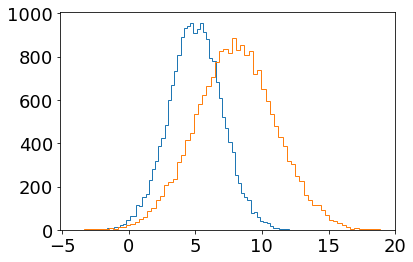

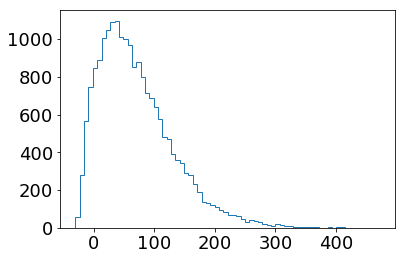

In [36]:
#mask = ~np.isnan(z_pr)
plt.hist(x_pr,bins=70,histtype="step")
plt.hist(y_pr,bins=70,histtype="step")
plt.figure()
plt.hist(z_pr,bins=70,histtype="step");

I don't know if there's a better way to do that, but this works at least in simple cases. I can't imagine there's any obstacle to this method anywhere, but it'd be worth taking some time to do a better job of understanding this.